# Homework 4
## Giacomo Menegatti 2122852

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import pandas as pd

%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}


## Finding the eccentricity $e$ to have the maximum angular deceleration at $f=\frac{\pi}{4}$
 
The equations used in this problem are $$r^2\dot f = h$$ $$r=\frac{p}{1+e\cos f} \implies \dot r = \frac{he}{p}\sin f$$
To find the maximum angular deceleration $-\ddot f$ I derive $\dot f$ twice (with $h$, $p$ and $e$ constants) obtaining $$\dot f = \frac{h}{r^2} = \frac{h}{p^2}(1+e\cos f)^2$$
$$ \ddot f= -2\frac{h^2e}{p^4}(1+e \cos f)^3\sin f$$
$$ \frac{d^3f}{dt^3}=-2\frac{h^2e}{p^4}(1+e\cos f)^2[-3e\sin^2 f + (1+e \cos f)\cos f]\dot f $$
Imposing $[...] = 0$, I obtain the equation $$e= \frac{\cos f}{3-4\cos^2 f}$$
Using $f=\frac{\pi}{4}$, I get $e=0.7071$

## Laplace to Heliocentric RF transformation
### Constant of the system

In [46]:
AU = 149597870707 #Astronomical Unit in m
G = 6.6743e-11
M_sun = 1.9891e30
mu = G*M_sun  #Gravitational parameter of the Sun
R_Earth = 6.378137e6  #Radius of the spherical Earth

#Latitude and longitude of Padua
long_PD = np.deg2rad(11 +52.3/60)
lat_PD = np.deg2rad(45 +24/60)



### Read the orbital elements from the file

In [47]:
# Read the file skipping the comments and the last column (;)
df = pd.read_csv('Elementi Orbitali (Meeus - MEE of date).m', delimiter='\s+', comment='%', header=None, usecols=[0,1,2,3])

planet_names = ['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']
planet = {}
for i, name in enumerate(planet_names):
  #Save the orbital elements in a dictionary. I pick blocks of 7 rows at every time because the last one is blank
  orbital_elements = {}
  orbital_elements['L'] = np.deg2rad(np.array(df.iloc[7*i]))
  orbital_elements['a'] = np.array(df.iloc[7*i+1])*AU
  orbital_elements['e'] = np.array(df.iloc[7*i+2])
  orbital_elements['i'] = np.deg2rad(np.array(df.iloc[7*i+3]))
  orbital_elements['Omega'] = np.deg2rad(np.array(df.iloc[7*i+4]))
  orbital_elements['pi'] = np.deg2rad(np.array(df.iloc[7*i+5]))

  #Save the dictionary with the planet name
  planet[name]=orbital_elements


### Get the Julian time at a specific date
For a given date Day-Month-Year hour the Julian time is given by 
$$JD_0 = D – 32075 + 1461 × (Y + 4800 + (M – 14)/12)/4
+ 367 × (M – 2 – (M – 14)/12 × 12)/12
–3 × ((Y + 4900 + (M – 14) / 12) / 100) /4$$
$$JD = JD_0 + F – 0.5$$
where $JD_0$ is the Julian date at noon and $JD$ the date at any fraction of day $F$ from the midnight.

In [48]:
def JD(Y=2000, M=1, D=1, h=0, m=0, s=0, TZ=0):
  '''Calculate the Julian Time from the Gregorian date'''
  # In python trunc keeps only the integer part. //, round and floor do not work with negative nubers
  C = np.trunc((M-14)/12)
  JD0 = D-32075 + np.trunc(1461*(Y+4800+C)/4) + np.trunc(367*(M-2-C*12)/12) - np.trunc(3*np.trunc((Y+4900+C)/100)/4)
  # Add the hour information and the Time Zone
  JD = JD0 - 0.5 - TZ/24 + (h+m/60+s/3600)/24
  return JD


### Definition of T, GMST and $\epsilon$

In [49]:
def T(JD):
  '''Return the time in centuries from J2000.0'''
  return (JD-2451545.0)/36525

def eps(JD):
  '''Inclination of the Earth axis in RADIANS'''
  t = T(JD)
  eps = 23.439291 - 0.0130042*t - 0.00059*t**2 + 0.001813*t**3
  return np.deg2rad(eps)

def GMST(Y, M, D, h=0, m=0, s=0, TZ=0):
  '''Greenwich Mean Sidereal Time'''
  t = T(JD(Y,M,D))  #The Julian date is calculated from the midnight at UT1=0
  GMST0 = 24110.54841 + 8640184.812866*t + 0.093104*t**2 - 0.0000062*t**3 #GMST at UT1=0
  
  F = (h - TZ + m/60 + s/3600)/24  #Time from UT1 in fraction of days
  GMST = GMST0 + F*24*3600*1.002737909350795 #GMST at the right time calculated in seconds
  return GMST*2*np.pi/(24*3600) #GMST angle in RADIANS



### Cartesian Position of a planet at a given date and time
The Inertial position is found by the Lagrangian position by reversing the transformation $$ \mathbf{r}_L =  R_z(\pi-\Omega)R_x(i)R_z(\Omega) \mathbf{r}_I $$
in $$ \mathbf{r}_I =  R_z(-\Omega)R_x(-i)R_z(\pi-\Omega) \mathbf{r}_L $$

In [50]:
def Rx(theta, v):
  '''Rotation to align to a vector along the x-axis'''
  return np.array([v[0], v[1]*np.cos(theta)+v[2]*np.sin(theta), -v[1]*np.sin(theta)+v[2]*np.cos(theta)])

def Rz(theta, v):
  '''Rotation to align to a vector around the z-axis'''
  return np.array([v[0]*np.cos(theta)+v[1]*np.sin(theta), -v[0]*np.sin(theta)+v[1]*np.cos(theta), v[2]])

def R_L2I(v, pi, i, Omega):
  '''Rotation from the Lagrange to the Inertial RF'''
  return Rz(-Omega, Rx( -i, Rz( Omega-pi, v )))

def orbital_elements(planet_name, JD):
  '''Returns the Orbital elements at a given Julian date'''
  t = T(JD)
  T_pol = np.array([1,t,t**2,t**3]) #Polynomial in T (1, T, T^2, T^3)
  orbital_elements = {}
  for x in planet[planet_name].keys():
    orbital_elements[x] = np.dot(planet[planet_name][x], T_pol)
  return orbital_elements


### Lagrange Coordinates from orbital elements
The Orbital elements contained in the file are $a,e,L=M+\Omega+\omega,i, \Omega, \pi = \omega+\Omega$. The simplest orbital angle to obtain is the eccentric anomaly $E$ by solving the Kepler's equation $M=E -e\sin E$, then the position and velocity of the body are given by $$\mathbf r = a(\cos E -e)\mathbf{\hat P} + a\sqrt{1-e^2}\sin E\mathbf{\hat Q}$$ $$ \mathbf{ \dot r} = -\frac{na^2}{r}\sin E \mathbf{\hat P} + \frac{na^2}{r}\sqrt{1-e^2}\cos E \mathbf{\hat Q}$$
$$ r = a(1-e\cos E) $$ 
$$\mu =n^2a^3 $$

In [51]:
def SolveKeplerEq(M,e, atol=1e-14):
  '''Solver of the Kepler's equation'''
  # This works only if M is between 0 and 2pi, so I have to rescalate it
  k = np.floor(M/(2*np.pi))
  M = M-k*2*np.pi           #Subtract all the complete orbits
  E = M
  Delta = 1e2
  while(Delta > atol):
    Delta = (E - e*np.sin(E) - M)/(1-e*np.cos(E))
    E = E - Delta
  return E

def Lagrange_coord(planet_name, JD):
  '''Coordinates of the planet in the Lagrange RF'''
  OE = orbital_elements(planet_name, JD)
  a = OE['a']
  e = OE['e']
  M = OE['L']-OE['pi']

  E = SolveKeplerEq(M,e)
  n = (mu*a**-3)**0.5
  r = a*(1-e*np.cos(E))

  X = np.array([a*(np.cos(E)-e), a*(1-e**2)**0.5*np.sin(E), 0]) 
  V = np.array([-n*a**2/r*np.sin(E), n*a*2/r*(1-e**2)**0.5*np.cos(E), 0])
  return X,V

def Inertial_coord(planet_name, JD):
  '''Inertial coordinates of a planet at a given Julian Date'''
  OE = orbital_elements(planet_name, JD)
  X, _ = Lagrange_coord(planet_name, JD)
  return R_L2I(X, OE['pi'], OE['i'], OE['Omega'])


### Orbits of the planets during 2024
Here I plotted the orbits of the inner planets from 1-1-2024 to 31-12-2024 in the Inertial RF

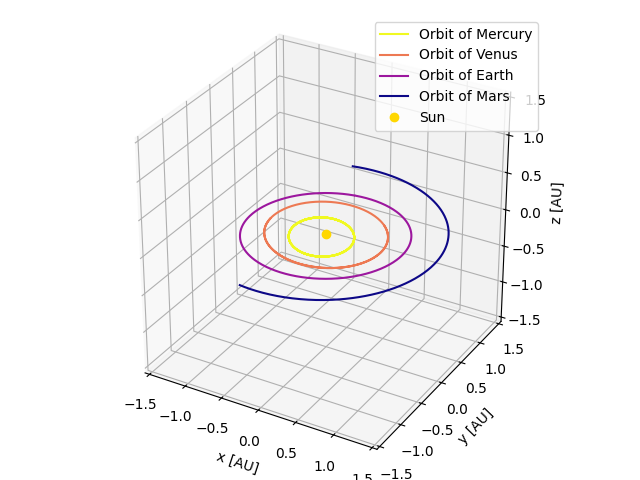

In [52]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
colors = cmap.plasma_r(np.linspace(0,1,4))
for c, name in zip(colors, ['Mercury','Venus', 'Earth', 'Mars']):
  trace = np.array([Inertial_coord(name,JD(2024,1,i)) for i in range(1,366)])
  ax.plot(trace[:,0]/AU, trace[:,1]/AU, trace[:,2]/AU, color=c, label = f'Orbit of {name}')
ax.plot(0,0,0, 'o', color='gold', label='Sun')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.5,1.5])
ax.set_xlabel('x [AU]')
ax.set_ylim([-1.5,1.5])
ax.set_ylabel('y [AU]')
ax.set_zlim([-1.5,1.5])
ax.set_zlabel('z [AU]')
ax.legend()
plt.tight_layout()
plt.show()


### Right Ascension and declination
The Right ascension and delcination is found by considering the polar coordiantes of a body in the Geocentric RF and rotating the RF to align it with the Earth equator. $$ \mathbf{r}_{GEO}= \mathbf{r}_I-\mathbf{r}_{Earth}$$ 
$$ \mathbf{r}_{EQ} = R_x(-\epsilon)\mathbf{r}_{GEO} $$

In [53]:
def Geo_coord(planet_name, JD):
  '''Coordinates in the Geocentric RF'''
  if planet_name == 'Sun': #The Sun has coordinates 0,0,0 in its RF 
    X =  - Inertial_coord('Earth', JD)
  else:
    X = Inertial_coord(planet_name, JD)- Inertial_coord('Earth', JD)
  return X

def polar_coord(r):
  '''Polar Coordinates from cartesian ones'''
  theta = np.arctan2(r[2],(r[0]**2+r[1]**2)**0.5) #Theta is the latitude
  phi = np.arctan2(r[1],r[0]) #Phi is the longitude
  return np.rad2deg(phi), np.rad2deg(theta)

def RA_dec(planet_name, JD):
  '''Right ascension and declination'''
  r_GEO = Geo_coord(planet_name, JD)
  r_EQ = Rx(-eps(JD), r_GEO)
  RA, dec = polar_coord(r_EQ)
  RA = RA/360*24 #R.A. is usually given in hours from 0 to 24
  RA = RA+24 if RA<0 else RA  #The values are remapped from -12 12 to 0 24
  return RA, dec


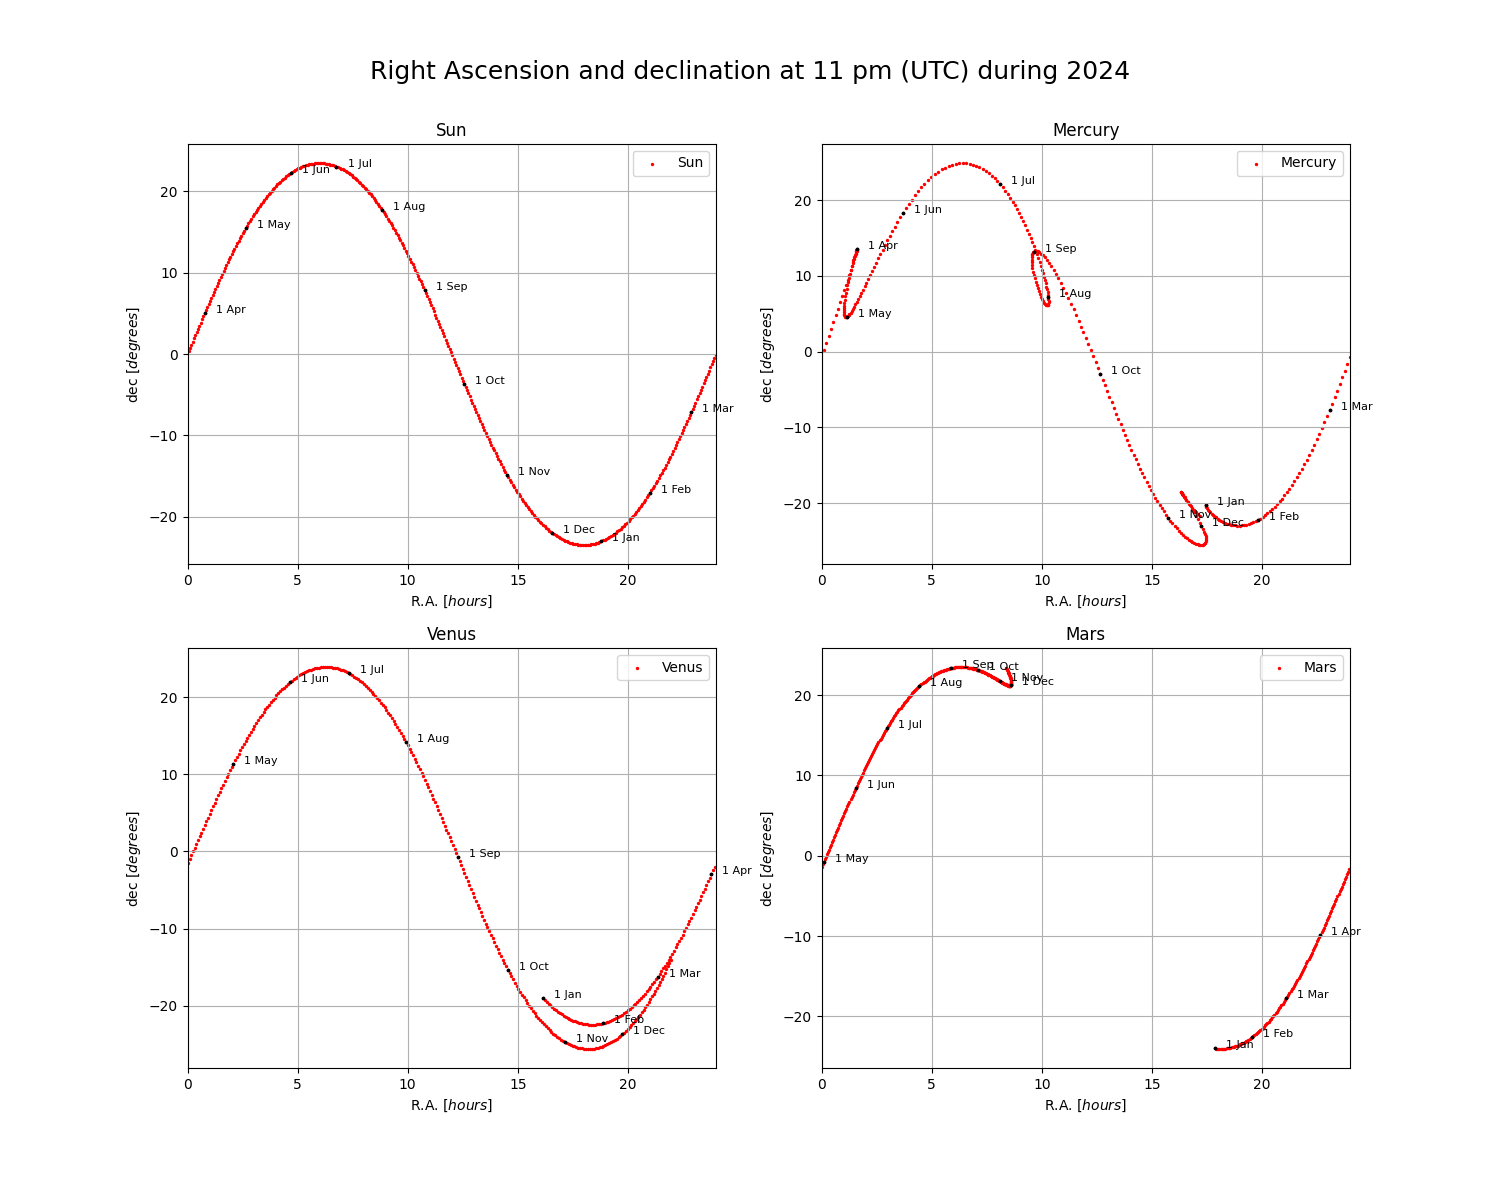

In [54]:
plt.figure(figsize=(15, 12))
plt.suptitle("Right Ascension and declination at 11 pm (UTC) during 2024", fontsize=18, y=0.95)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for n, planet_name in enumerate(['Sun', 'Mercury', 'Venus', 'Mars']):
  # add a new subplot iteratively
  ax = plt.subplot(2, 2, n + 1)
  ax.set_title(f'{planet_name}')
  coords = np.array([RA_dec(planet_name,  JD(2024,1,d, 23)) for d in np.arange(1,366,1)])
  ax.scatter(coords[:,0], coords[:,1], color='r', s=2, label=f'{planet_name}')
  #Plotting the position at the beginning of each month
  for i, month in enumerate(month_names):
    coords = RA_dec(planet_name,  JD(2024,i+1,1, 23))
    ax.scatter(coords[0], coords[1], color='k', s=3)
    ax.text(coords[0]+0.5, coords[1], f'1 {month}', fontsize=8)

  ax.grid()
  ax.set_xlim(0,24)
  ax.set_xlabel('R.A. $[hours]$')
  ax.set_ylabel('dec $[degrees]$')
  ax.legend()




To be sure of the calculation, I compared this results with the ephemeridis calculated in the **Astronomical Almanac 2020** for Venus, 1st January 2020 at 0 UT1.

In [55]:
expected_RA = (21+9/60+44.587/3600)
expected_dec = -(18+15/60+56.18/3600)

RA, dec = RA_dec('Venus', JD(2020,1,1))
print('Expected values')
print(f'RA: {expected_RA}, dec: {expected_dec}')
print('Calculated values')
print(f'RA: {RA}, dec: {dec}')
print(f'Difference RA: {100*(RA/expected_RA-1):.2e}%, dec: {100*(dec/expected_dec-1):.2e}%')


Expected values
RA: 21.162385277777776, dec: -18.265605555555556
Calculated values
RA: 21.163271261633334, dec: -18.26182607847069
Difference RA: 4.19e-03%, dec: -2.07e-02%


### Altitude and Azimuth
The Equatorial J2000.0 coordinates are converted in local Altitude and Azimuth by applying the transformation
$$ \mathbf{r}_{Loc}=R_x(\frac{\pi}{2}-\phi)R_z(\lambda + \frac{\pi}{2})R_z(\theta_{GMST})R_x(-\epsilon)\mathbf{r}_{GEO} $$
The time is calculated at 11 pm in the tocal timezone (+1 UTC) ant the radius of the Earth is subtracted to obtain before obtaining the final result (the Earth is considered a perfect sphere).

In [56]:
def Alt_Az(planet_name, JD, GMST, lat, long):
  '''Returns the altitude and azimuth in DEGREES'''
  r_GEO = Geo_coord(planet_name, JD)
  r_AltAz = Rx(np.pi/2-lat, Rz(long+np.pi/2+GMST, Rx(-eps(JD), r_GEO)))
  r_AltAz = r_AltAz - np.array([0,0,R_Earth]) #The RF is aligned with the posistion on the surface, then traslated up to it

  # Now the RF is East-North-Up
  Alt = np.rad2deg(np.arctan2(r_AltAz[2],(r_AltAz[0]**2+r_AltAz[1]**2)**0.5))
  Az = np.rad2deg(np.arctan2(r_AltAz[0],r_AltAz[1]))
  Az = Az+360 if Az<0 else Az # The Azimuth is rescaled from -180 180 to 0 360
  return Alt, Az


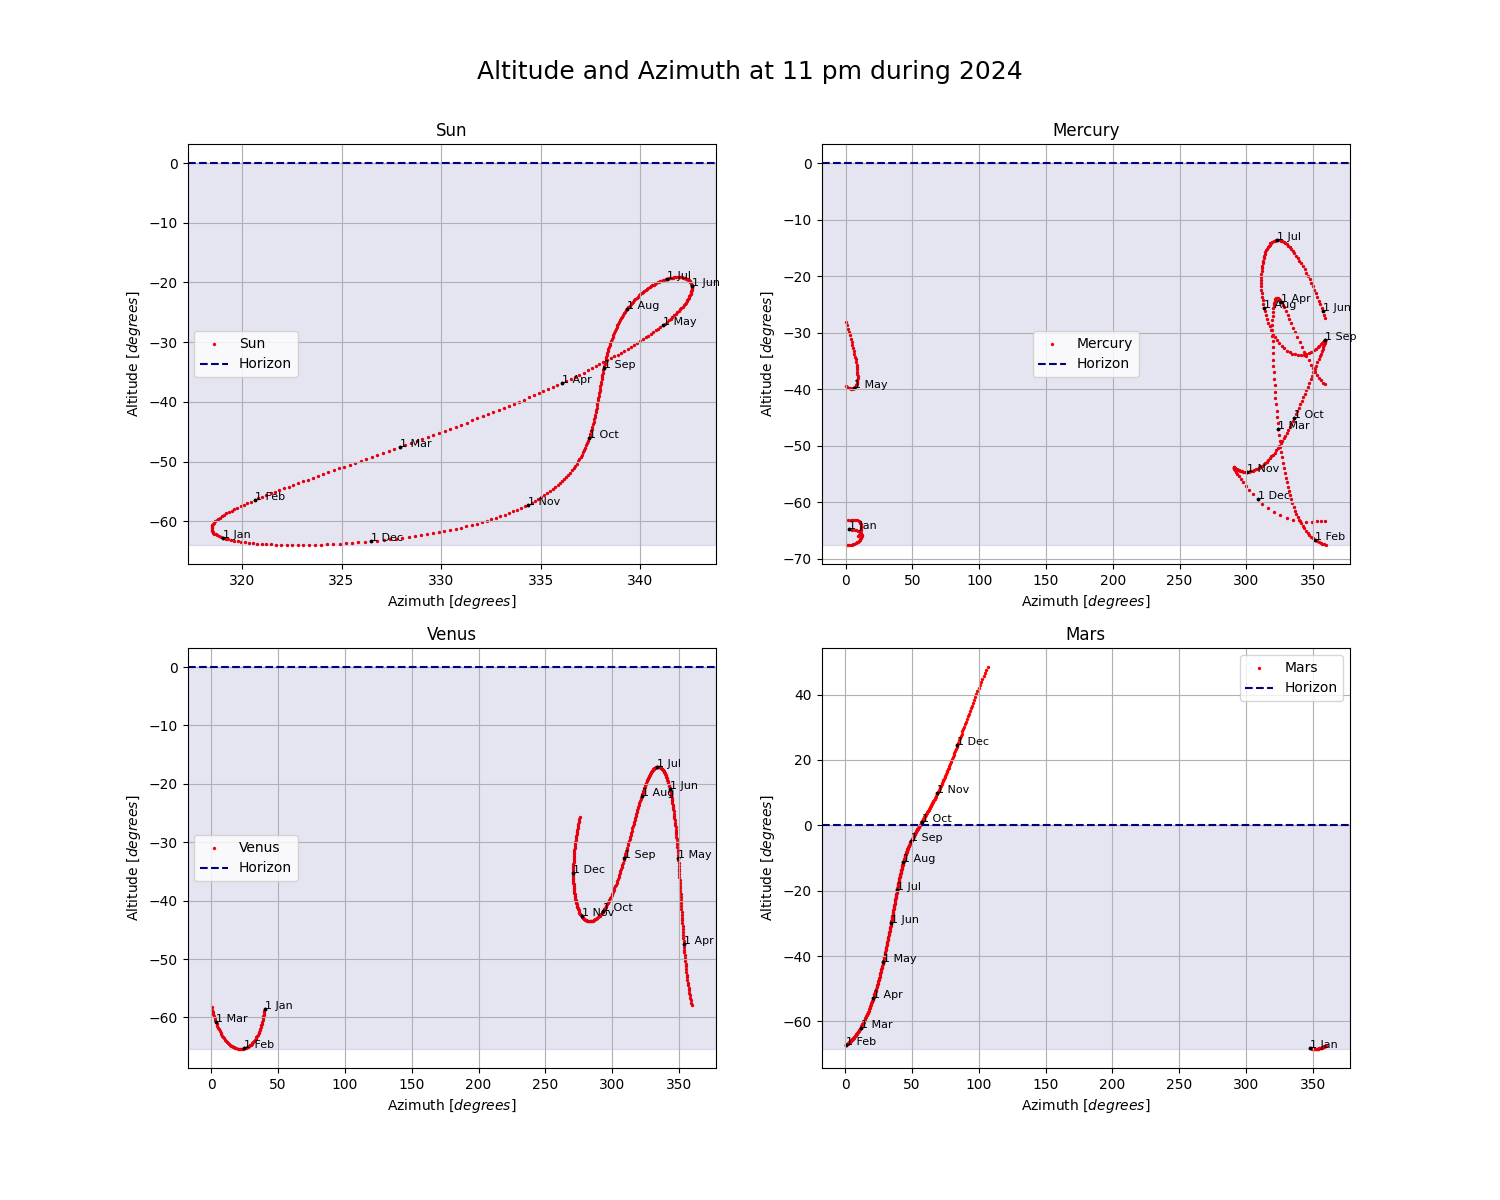

In [57]:
plt.figure(figsize=(15, 12))
plt.suptitle("Altitude and Azimuth at 11 pm during 2024", fontsize=18, y=0.95)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for n, planet_name in enumerate(['Sun', 'Mercury', 'Venus', 'Mars']):
  # add a new subplot iteratively
  ax = plt.subplot(2, 2, n + 1)
  ax.set_title(f'{planet_name}')
  coords = np.array([Alt_Az(planet_name, JD(2024,1,d,23, TZ=1), GMST(2024,1,d,23, TZ=1), lat_PD, long_PD) for d in range(1,366)])
  ax.scatter(coords[:,1], coords[:,0], color='r', s=2, label=f'{planet_name}')
  ax.axhline(0, color='navy', linestyle='dashed', label='Horizon')

  ax.axhspan(min(coords[:,0]), 0, color='navy', alpha=0.1)
  #Plotting the position at the beginning of each month
  for i, month in enumerate(month_names):
    coords = Alt_Az(planet_name, JD(2024,i+1,1,23, TZ=1), GMST(2024,i+1,1,23, TZ=1), lat_PD, long_PD)
    ax.scatter(coords[1], coords[0], color='k', s=3)
    ax.text(coords[1], coords[0], f'1 {month}', fontsize=8)
  
  

  ax.grid()
  ax.set_xlabel('Azimuth $[degrees]$')
  ax.set_ylabel('Altitude $[degrees]$')
  ax.legend()


From the plot it appears that no planet is above the horizon at 11 pm except for Mars, which is visible from September 26.

### Trace of the Sun and Venus at 10 UT and 20 UT
In this part of the homework I used the function created before to trace the position of the Sun and of Venus in the sky at 10 UT and 20 UT. The Sun draws an 8-like figure called analemma.

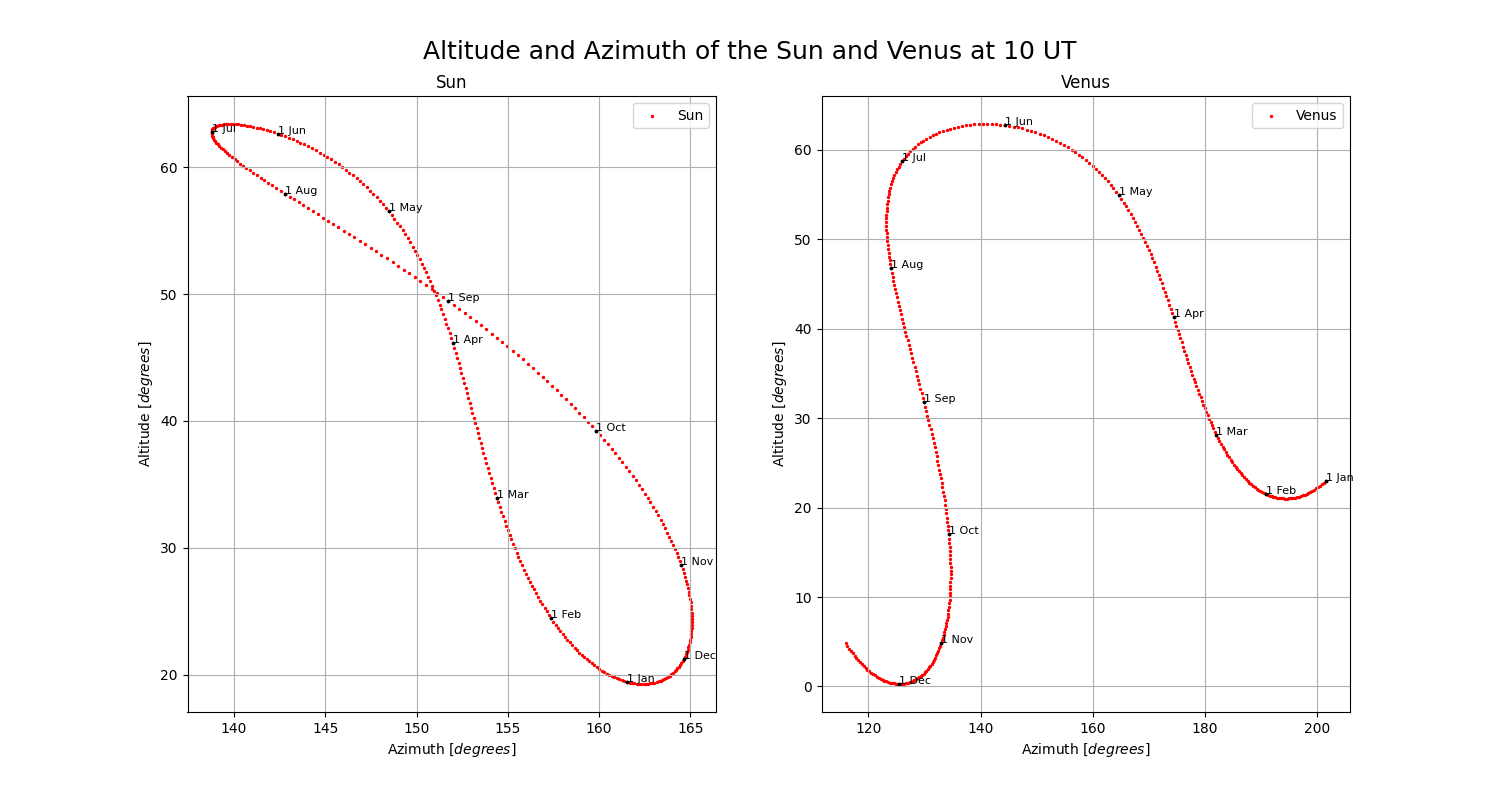

In [58]:
plt.figure(figsize=(15, 8))
plt.suptitle("Altitude and Azimuth of the Sun and Venus at 10 UT", fontsize=18, y=0.95)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

h=10
for n, planet_name in enumerate(['Sun','Venus']):
  # add a new subplot iteratively
  ax = plt.subplot(1, 2, n + 1)
  ax.set_title(f'{planet_name}')
  coords = np.array([Alt_Az(planet_name, JD(2024,1,d,h, TZ=0), GMST(2024,1,d,h, TZ=0), lat_PD, long_PD) for d in range(1,366)])
  ax.scatter(coords[:,1], coords[:,0], color='r', s=2, label=f'{planet_name}')
  #ax.axhline(0, color='navy', linestyle='dashed', label='Horizon')

  #ax.axhspan(min(coords[:,0]), 0, color='navy', alpha=0.1)
  #Plotting the position at the beginning of each month
  for i, month in enumerate(month_names):
    coords = Alt_Az(planet_name, JD(2024,i+1,1,h, TZ=0), GMST(2024,i+1,1,h, TZ=0), lat_PD, long_PD)
    ax.scatter(coords[1], coords[0], color='k', s=3)
    ax.text(coords[1], coords[0], f'1 {month}', fontsize=8)
  
  

  ax.grid()
  ax.set_xlabel('Azimuth $[degrees]$')
  ax.set_ylabel('Altitude $[degrees]$')
  ax.legend()


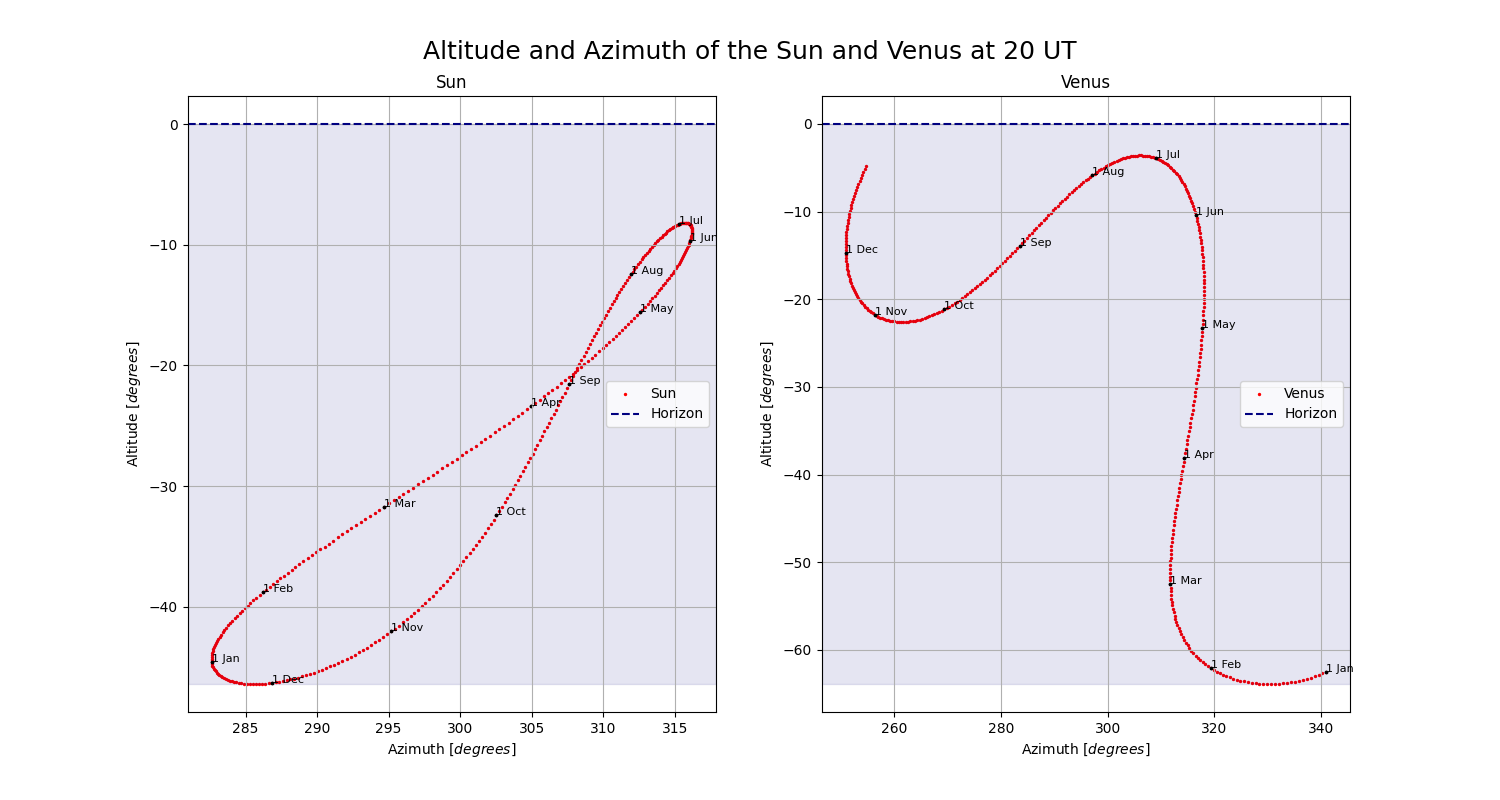

In [59]:
plt.figure(figsize=(15, 8))
plt.suptitle("Altitude and Azimuth of the Sun and Venus at 20 UT", fontsize=18, y=0.95)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

h=20
for n, planet_name in enumerate(['Sun','Venus']):
  # add a new subplot iteratively
  ax = plt.subplot(1, 2, n + 1)
  ax.set_title(f'{planet_name}')
  coords = np.array([Alt_Az(planet_name, JD(2024,1,d,h, TZ=0), GMST(2024,1,d,h, TZ=0), lat_PD, long_PD) for d in range(1,366)])
  ax.scatter(coords[:,1], coords[:,0], color='r', s=2, label=f'{planet_name}')
  ax.axhline(0, color='navy', linestyle='dashed', label='Horizon')

  ax.axhspan(min(coords[:,0]), 0, color='navy', alpha=0.1)
  #Plotting the position at the beginning of each month
  for i, month in enumerate(month_names):
    coords = Alt_Az(planet_name, JD(2024,i+1,1,h, TZ=0), GMST(2024,i+1,1,h, TZ=0), lat_PD, long_PD)
    ax.scatter(coords[1], coords[0], color='k', s=3)
    ax.text(coords[1], coords[0], f'1 {month}', fontsize=8)
  
  

  ax.grid()
  ax.set_xlabel('Azimuth $[degrees]$')
  ax.set_ylabel('Altitude $[degrees]$')
  ax.legend()
